# load utilities

In [1]:
%matplotlib inline
%run '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/notebooks/00_manuscript/utilities.py'
%run '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/notebooks/00_manuscript/spectrogramming.py'
%run '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/notebooks/00_manuscript/segmentation.py'
%run '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/notebooks/00_manuscript/annotation.py'
all_wav_raw = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/'
all_voc_clips_dirs = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmentation/final/vocalization_clips/'
all_bg_clips_dirs = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmentation/final/background_clips/'
test_set_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/annotated/annotations_csv/all_annotations.csv'

# generate hdbscan labels

In [2]:
#get the final umap embeddings

coords_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmentation/final/umap_coordinates/'
umap_embeddings = os.listdir(coords_dir)
print('available embeddings:')
print(umap_embeddings)

In [3]:
#choose the species to process from the above list get the .feather file with each spectrogram, its source_file name, and its umap coordinates
species = 'SW'

coords = [i for i in umap_embeddings if i.startswith(species)][0]
save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/'
save_name_root = coords.split(('.'))[0]

print('getting umap embedding for', coords)
print('files associated with this embedding with have the prefix', save_name_root)
df_umap = pd.read_feather(coords_dir + coords)

getting umap embedding for SW_27289x128x128_version5.feather
files associated with this embedding with have the prefix SW_27289x128x128_version5


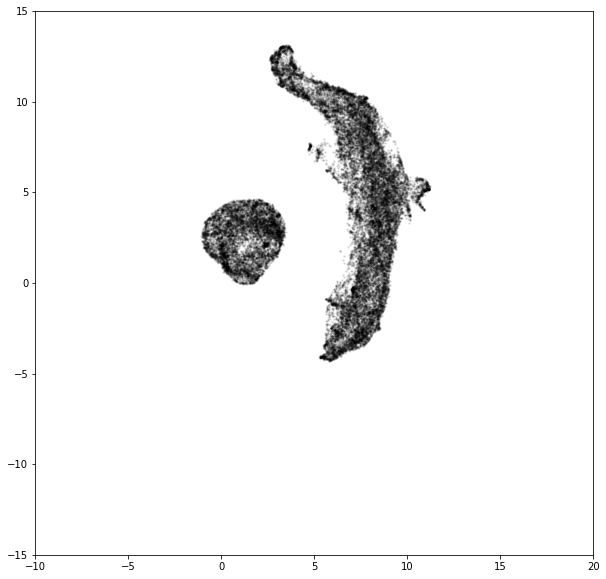

In [1154]:
#show the umap plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

pups = [i.split('_clip')[0] for i in df_umap['source_file']]
colmap = {name: n for n, name in enumerate(set(pups))}
c = [colmap[name] for name in pups]
ax = plt.scatter(
    df_umap['umap1'],
    df_umap['umap2'],
    c = 'k',
    s = 2,
    alpha = .1, 
    cmap='viridis')

xlims = [-10,20]
ylims = [-15,15]
plt.xlim(xlims)
plt.ylim(ylims)

plt.show()



# get cluster labels

In [648]:
#do SDBSCAN on UMAP coordinate JUST to separate the two clusters (only necessary if there is not a threshold in 1 umap dimensiion)
import hdbscan
data=df_umap[['umap1', 'umap2']]

clusterer = hdbscan.HDBSCAN(min_cluster_size=100, allow_single_cluster=True).fit(data)
color_palette = sns.color_palette(['deeppink', 'grey'])
cluster_colors = [color_palette[x] for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

df_umap['label'] = clusterer.labels_


Text(0.5, 1.0, 'cluster_label=1')

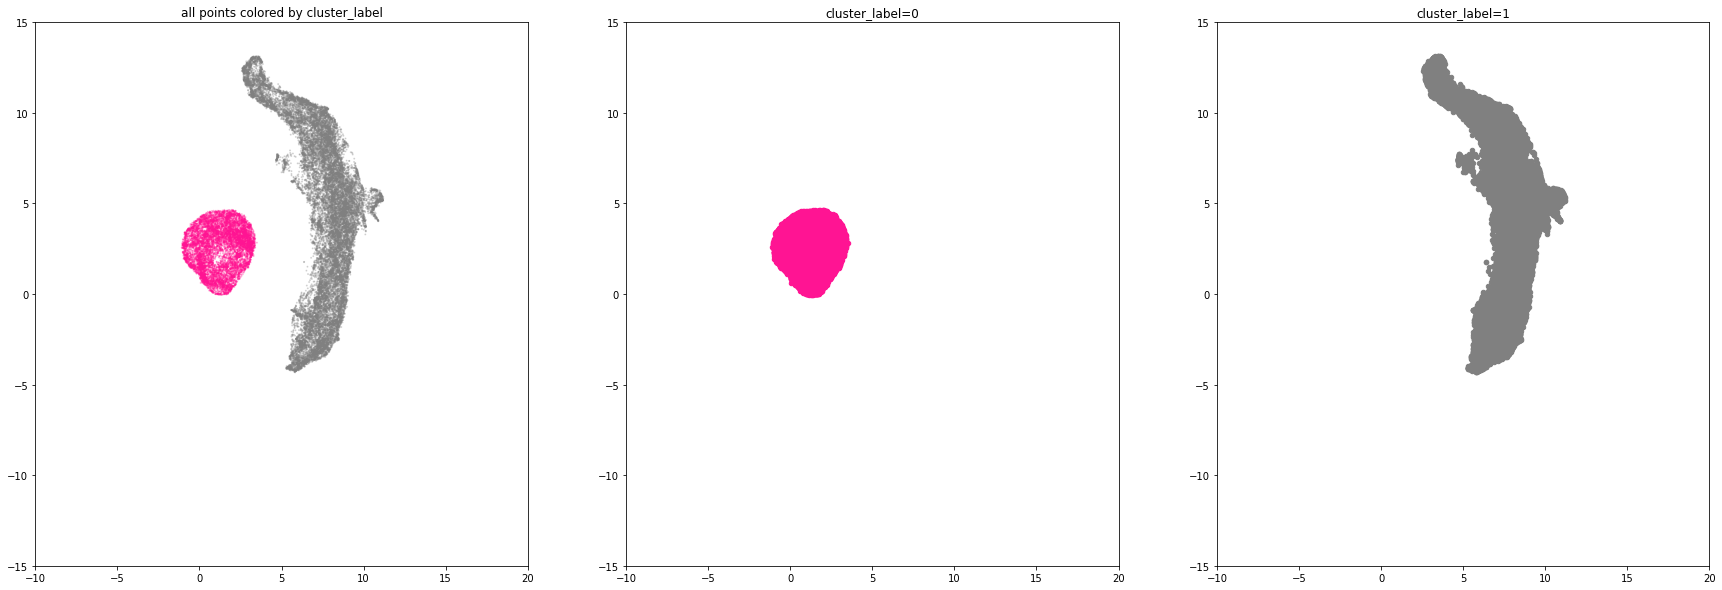

In [649]:
#show the umap plot with cluster labels and verify they correspond exactly to the clusters you see
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)
ax3.set_xlim(xlims)
ax3.set_ylim(ylims)

ax1.scatter(
    df_umap['umap1'],
    df_umap['umap2'],
    c = cluster_colors,
    s = 1,
    alpha = .25)

ax1.set_title('all points colored by cluster_label')

ax2.scatter(
    df_umap['umap1'].loc[df_umap['label']==0],
    df_umap['umap2'].loc[df_umap['label']==0],
    c = 'deeppink',
    s = 20,
    alpha = 1)
ax2.set_title('cluster_label=0')

ax3.scatter(
    df_umap['umap1'].loc[df_umap['label']==1],
    df_umap['umap2'].loc[df_umap['label']==1],
    c = 'grey',
    s = 20,
    alpha = 1)
ax3.set_title('cluster_label=1')

In [8]:
#count vocalizations
print('label=0:', len(df_umap.loc[df_umap['label'] == 0]))
print('label=1:', len(df_umap.loc[df_umap['label'] == 1]))


label=0: 21239
label=1: 45629


In [1007]:
count_dict = {'BW': {'label_0':9582, 'label_1': 20548}, 
              'GO': {'label_0':21239, 'label_1': 45629}, 
              'LL':{'label_0':9748, 'label_1': 8623}, 
              'SW':{'label_0':4928, 'label_1': 22361}, 
              'NB':{'label_0':9210, 'label_1': 24869}, 
              'BK':{'label_0':10115, 'label_1': 32129}, 
              'PO':{'label_0':3571, 'label_1': 6897}, 
              'LO':{'label_0':2839, 'label_1': 16590}, 
              'MU':{'label_0':24871, 'label_1': 0}, 
              'MZ':{'label_0':10535, 'label_1': 0}}

#set path to save
save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/00_params/'
save_name = 'label_counts'

#save
save_parameters(params = count_dict,
                save_dir=save_dir, 
                save_name=save_name)

This file already exists in save_dir: label_counts
overwrite? y/ny
are you sure? y/ny
ok - replaced existing file


In [153]:
#check hdbscan hasn't dropped an vocalilzations for deer mice
for key in list(count_dict.keys()):
    print(key, ':', count_dict[key]['label_0']+count_dict[key]['label_1'])

BW : 30130
GO : 66868
LL : 18371
SW : 27289
NB : 34079
BK : 42244
PO : 10468
LO : 19429
MU : 24871
MZ : 10535


In [154]:
#save this record that the clusterer worked as expected

if save_name_root+'_labeled.jpeg' not in os.listdir(save_dir):
    plt.savefig(save_dir+save_root+'_labeled.jpeg', dpi=600)
    print('saved to ', save_dir+save_root+'_labeled.jpeg')
else: 
    print('file already exists.')

file already exists.


In [146]:
#save the new dataframe with spectrograms, source_files, umap_coordinates, an labels

if save_name_root+'_labeled.feather' not in os.listdir(save_dir):
    df_umap.to_feather(save_dir+save_root+'_labeled.feather')
    print('saved to ', save_dir+save_root+'_labeled.feather')
else: 
    print('file already exists.')

file already exists.


# generate human labels

In [1155]:
#make the directories you need 
#set iteration_number to iteration1 (or something) if this is the first time annotating this embedding
#update iteration_number if you want to go back and annotate more vocalizations and keep them separate from previous annotations
iteration_number = 'iteration2'

make_annotations_directories(save_dir, iteration=iteration_number)

annotations directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/NB/annotations

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/NB/annotations/00_params

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/NB/annotations/in_progress

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/NB/annotations/in_progress/hdbscanlabel0

made 00_params directory at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/NB/annotations/in_progress/hdbscanlabel0/iteration2

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/NB/annotations/in_progress/hdbscanlabel1

made 00_params directory at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/mode

In [1156]:
#load the labeled spectrogram embeddings
labeled_embedding = [save_dir+i for i in os.listdir(save_dir) if i.endswith('.feather')][0]
print('getting umap embedded spectrograms with labels for', labeled_embedding)
umap_labeled = pd.read_feather(labeled_embedding)
print('done.')

getting umap embedded spectrograms with labels for /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/NB/NB_34079x128x128_version5_labeled.feather
done.


In [1157]:
umap_labeled['label'].unique()

array([1, 0])

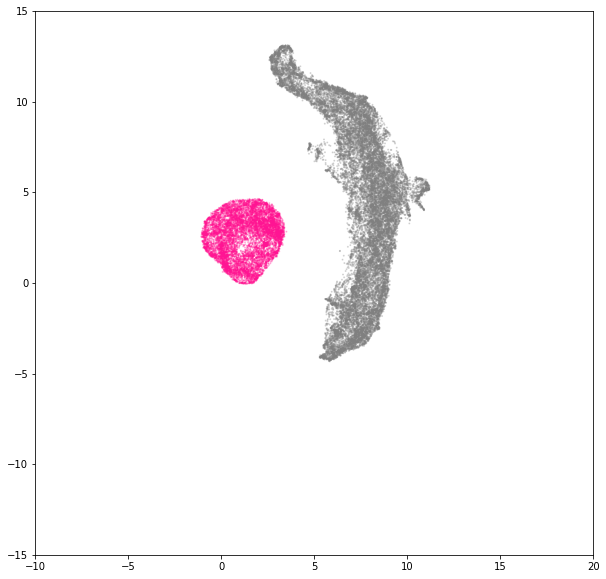

In [1158]:
#show the labeled embedding
color_palette = sns.color_palette(['deeppink', 'grey'])
cluster_colors = [color_palette[x] for x in umap_labeled['label']]
plt.figure(figsize=(10,10))
xlims = [-10,20]
ylims = [-15,15]
plt.xlim(xlims)
plt.ylim(ylims)
plt.scatter(
    umap_labeled['umap1'],
    umap_labeled['umap2'],
    c = cluster_colors,
    s = 1,
    alpha = .25)

In [1159]:
#or save new parameters after confirming twice you want to overwrite
clips_dir = all_voc_clips_dirs+species+'/'
print('clips_dir is', clips_dir)
sampling_params = {'species': species,
                   'num_to_sample':6000, 
                   'random_state':123456, 
                   'hdbscan_label':0, 
                   'sampling_iteration':2, 
                   'clips_dir':clips_dir, 
                   'type':'sampling vocalizations from umap'}

# #set paths
params_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+sampling_params['species']+'/annotations/00_params/'
params_save_name = sampling_params['species'] + '_hdbscanlabel'+str(sampling_params['hdbscan_label'])+'_iteration'+str(sampling_params['sampling_iteration'])

#save
save_parameters(params = sampling_params,
                save_dir=params_save_dir, 
                save_name=params_save_name)
    

clips_dir is /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmentation/final/vocalization_clips/NB/
making a new params file...
saved the params file to:
 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/NB/annotations/00_params/NB_hdbscanlabel0_iteration2


# choose parameters for hand labeling

In [1160]:
# check if sampling params already exist
print(os.listdir(params_save_dir))

['NB_hdbscanlabel1_iteration1.json', 'NB_hdbscanlabel0_iteration2.json', 'NB_hdbscanlabel0_iteration1.json']


In [1161]:
#downsample 
sampling_params = load_parameters(save_dir=params_save_dir, 
                                  save_name='NB_hdbscanlabel0_iteration2')

if sampling_params['species'] not in ['MU', 'MZ']:
    ds_df = sample_vocs(frame = umap_labeled, 
                              num_to_sample = sampling_params['num_to_sample'], 
                              label_to_sample = sampling_params['hdbscan_label'], 
                              random_state = sampling_params['random_state'])

if sampling_params['species'] in ['MU', 'MZ']: #if MU or MZ, samle from all vocs
    ds_df = umap_labeled.sample(n=sampling_params['num_to_sample'], 
                                random_state =  sampling_params['random_state'])
    
ds_df = ds_df.reset_index(drop=True)
df_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+sampling_params['species']+'/annotations/hdbscan_label_'+str(sampling_params['hdbscan_label'])+'/'
df_save_name = sampling_params['species']+'_'+'downsampled_for_labeling_'+str(sampling_params['hdbscan_label'])+'_iteration'+str(sampling_params['sampling_iteration'])+'.feather'

assert os.path.exists(os.path.join(df_save_dir))
ds_df.to_feather(os.path.join(df_save_dir+df_save_name))
print('saved sampled vocalizations to:\n\t', os.path.join(df_save_dir+df_save_name))

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/NB/annotations/00_params/NB_hdbscanlabel0_iteration2
saved sampled vocalizations to:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/NB/annotations/hdbscan_label_0/NB_downsampled_for_labeling_0_iteration2.feather


In [1162]:
#load sampled vocalizations
ds_df = pd.read_feather(os.path.join(df_save_dir+df_save_name))

#check how many are from pups in the test set
test_df = pd.read_csv(test_set_path)
in_test_set = check_test_set(ds_df, test_df)
print(len(in_test_set), 'vocs come from pups in the test set')
print('dropping them...')

#drop them
ds_df = ds_df.loc[~ds_df['source_file'].isin(in_test_set)]
print('dropped', len(in_test_set), 'vocs...')
print('there are', len(ds_df), 'remaining...')
print('done.')

1503 vocs come from pups in the test set
dropping them...
dropped 1503 vocs...
there are 4497 remaining...
done.


In [1163]:
#if this is iteration2, check how many are from pups in previous annotations
species = sampling_params['species']
iteration1_source_files = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/in_progress/hdbscanlabel0/iteration1/completed_source_files.npy'
iteration1_source_files = np.load(iteration1_source_files)

if sampling_params['species'] == 'MU':
    iteration2_source_files = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/in_progress/hdbscanlabel0/iteration2/completed_source_files.npy'
    iteration2_source_files = np.load(iteration2_source_files)
    already_done = [i for i in ds_df['source_file'] if (i in iteration1_source_files) or (i in iteration2_source_files)]   

already_done = [i for i in ds_df['source_file'] if i in iteration1_source_files]   
ds_df = ds_df.loc[~ds_df['source_file'].isin(already_done)]
print(len(already_done), 'vocs are already annotated')
print('dropping them...')
print('there are', len(ds_df), 'remaining...')
print('done.')


1467 vocs are already annotated
dropping them...
there are 3030 remaining...
done.


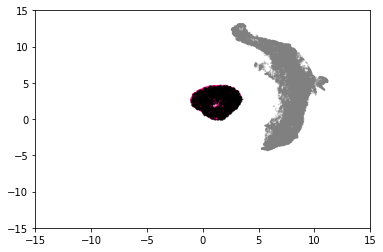

In [1164]:
# plot them on top of all vocs
color_palette = sns.color_palette(['deeppink', 'grey'])
cluster_colors = [color_palette[x] for x in umap_labeled['label']]

xlims = [-15,15]
ylims = [-15,15]
plt.xlim(xlims)
plt.ylim(ylims)

plt.scatter(
    umap_labeled['umap1'],
    umap_labeled['umap2'],
    c = cluster_colors,
    s = .7,
    alpha = .25)

plt.scatter(
    ds_df['umap1'],
    ds_df['umap2'],
    c = 'k',
    s = 1,
    alpha = .5)

loading saved annotations...
you already annotated 2962 vocalizations from this species, label, and iteration...
saving progress...
vocalization 2962 of 3030 ...
NB_28556x27320_ltr1_pup2_ch3_6400_m_306_314_fr0_p13_2021-08-12_12-41-41_clip_76.wav


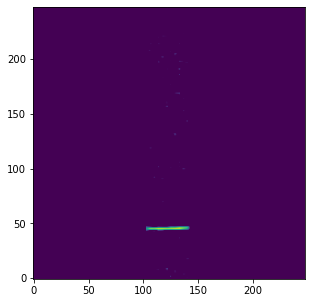

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated.
ok - none
saving progress...
vocalization 2963 of 3030 ...
NB_28556x27320_ltr1_pup2_ch3_6400_m_306_314_fr0_p13_2021-08-12_12-41-41_clip_209.wav


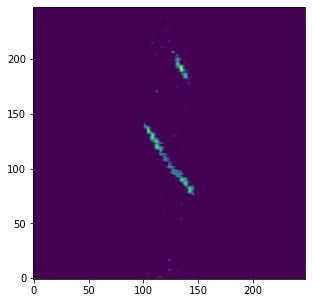

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2964 of 3030 ...
NB_28556x27320_ltr1_pup5_ch6_5700_m_307_306_fr0_p13_2021-08-12_12-41-41_clip_131.wav


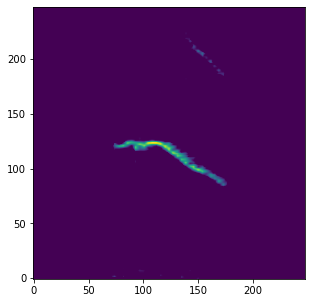

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2965 of 3030 ...
NB_28556x27320_ltr2_pup1_ch2_2400_m_345_273_fr0_p5_2021-11-17_09-22-32_clip_614.wav


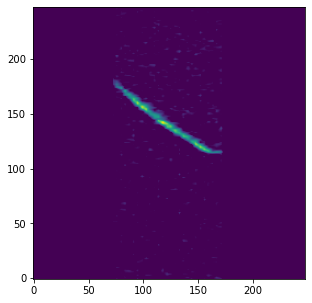

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2966 of 3030 ...
NB_28556x27320_ltr3_pup3_ch4_4500_m_353_304_fr0_p7_2021-12-14_11-27-29_clip_513.wav


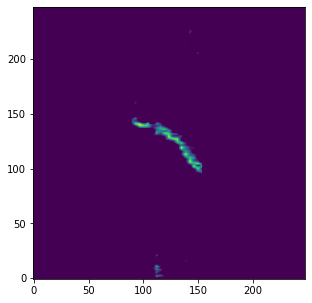

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2967 of 3030 ...
NB_28556x27320_ltr1_pup5_ch6_5700_m_307_306_fr0_p13_2021-08-12_12-41-41_clip_356.wav


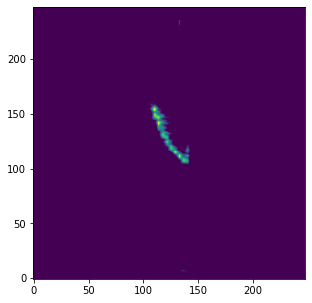

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2968 of 3030 ...
NB_28995x28876_ltr1_pup2_ch3_6400_f_321_318_fr0_p13_2021-08-12_12-12-41_clip_171.wav


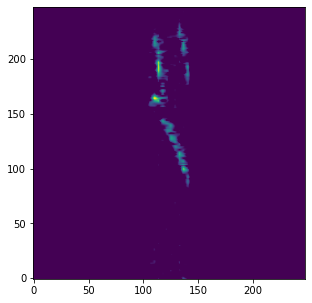

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2969 of 3030 ...
NB_28995x28876_ltr1_pup1_ch2_6900_m_318_302_fr0_p13_2021-08-12_12-12-41_clip_990.wav


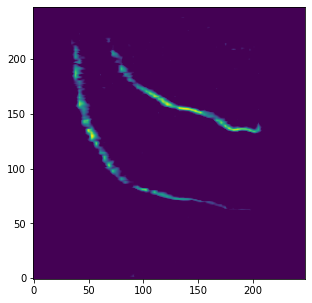

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2970 of 3030 ...
NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13_clip_775.wav


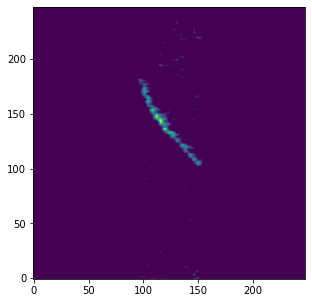

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2971 of 3030 ...
NB_28306x26626_ltr1_pup1_ch2_5400_m_316_293_fr0_p11_2021-10-04_10-04-13_clip_314.wav


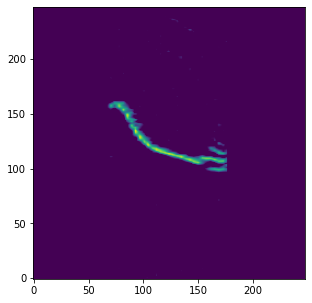

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2972 of 3030 ...
NB_28556x27320_ltr1_pup5_ch6_5700_m_307_306_fr0_p13_2021-08-12_12-41-41_clip_115.wav


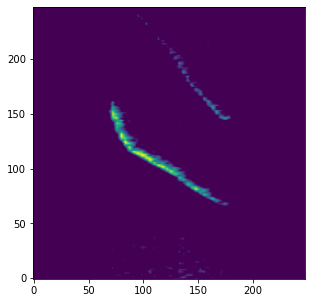

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2973 of 3030 ...
NB_28995x28876_ltr1_pup1_ch2_6900_m_318_302_fr0_p13_2021-08-12_12-12-41_clip_950.wav


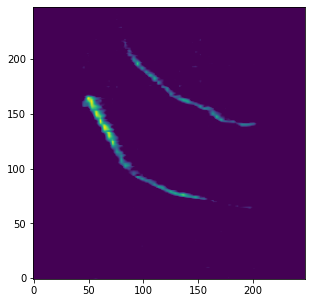

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2974 of 3030 ...
NB_28321x27533_ltr1_pup2_ch3_4900_f_325_273_fr0_p11_2021-08-11_12-26-05_clip_56.wav


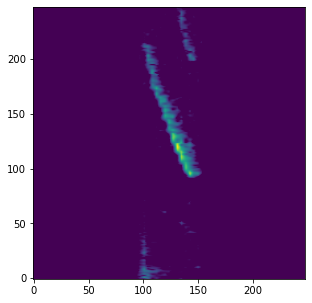

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2975 of 3030 ...
NB_28995x28876_ltr2_pup1_ch2_6700_m_334_327_fr0_p9_2021-10-06_11-26-13_clip_226.wav


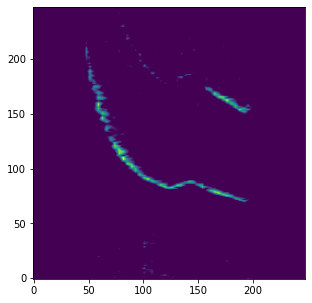

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2976 of 3030 ...
NB_28995x28876_ltr1_pup1_ch2_6900_m_318_302_fr0_p13_2021-08-12_12-12-41_clip_532.wav


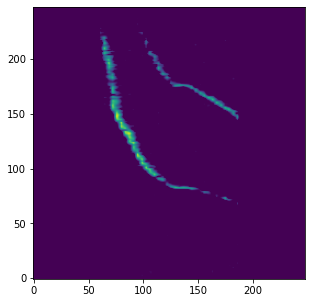

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2977 of 3030 ...
NB_28556x27320_ltr1_pup2_ch3_6400_m_306_314_fr0_p13_2021-08-12_12-41-41_clip_552.wav


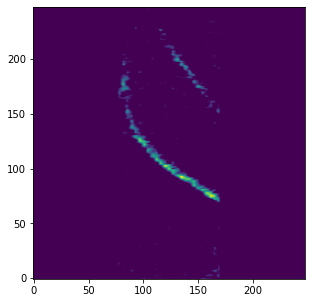

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2978 of 3030 ...
NB_28306x26626_ltr1_pup2_ch3_5100_m_327_298_fr0_p11_2021-10-04_10-04-13_clip_352.wav


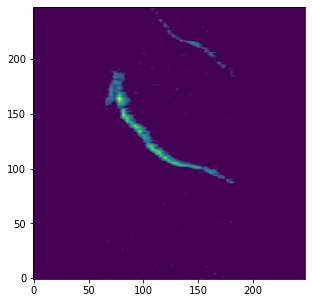

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2979 of 3030 ...
NB_26785x28444_ltr1_pup1_ch2_8000_m_316_320_fr0_p13_2021-09-27_10-05-33_clip_189.wav


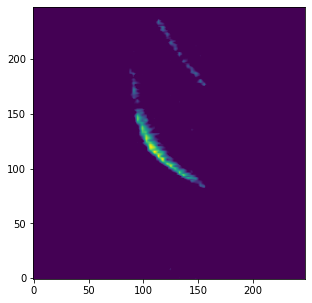

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2980 of 3030 ...
NB_28307x26627_ltr1_pup1_ch2_3500_m_356_296_fr0_p5_2021-12-15_11-10-35_clip_162.wav


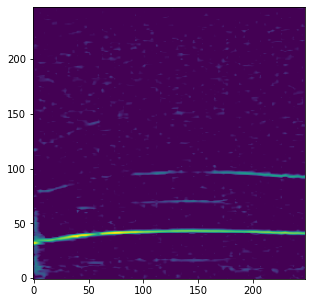

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated.
ok - none
saving progress...
vocalization 2981 of 3030 ...
NB_26785x28444_ltr1_pup1_ch2_8000_m_316_320_fr0_p13_2021-09-27_10-05-33_clip_4.wav


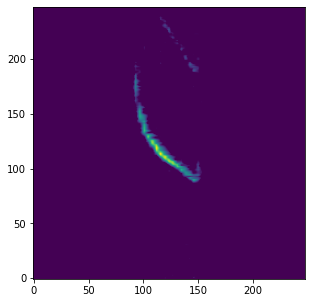

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2982 of 3030 ...
NB_26785x28444_ltr1_pup1_ch2_8000_m_316_320_fr0_p13_2021-09-27_10-05-33_clip_608.wav


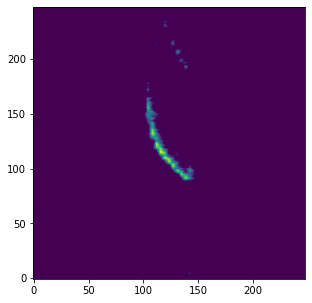

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2983 of 3030 ...
NB_26481x26788_ltr1_pup1_ch2_3800_f_343_281_fr0_p9_2021-08-06_12-59-17_clip_604.wav


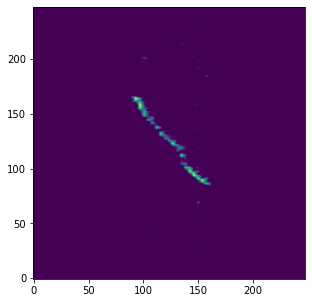

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2984 of 3030 ...
NB_28556x27320_ltr1_pup2_ch3_6400_m_306_314_fr0_p13_2021-08-12_12-41-41_clip_96.wav


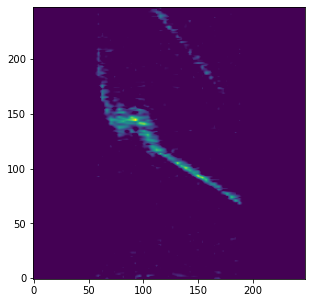

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2985 of 3030 ...
NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13_clip_691.wav


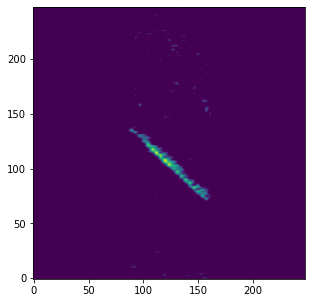

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2986 of 3030 ...
NB_28995x28876_ltr2_pup1_ch2_6700_m_334_327_fr0_p9_2021-10-06_11-26-13_clip_46.wav


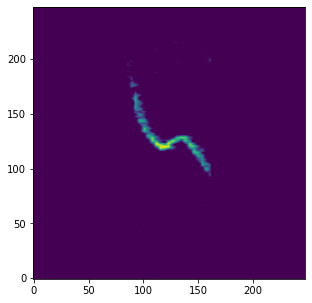

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2987 of 3030 ...
NB_26785x28444_ltr1_pup2_ch3_7700_f_317_314_fr0_p13_2021-09-27_10-05-33_clip_82.wav


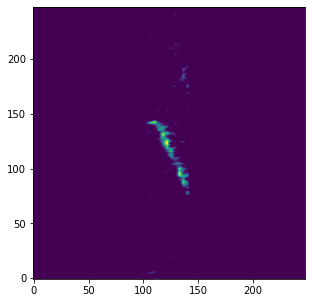

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2988 of 3030 ...
NB_28556x27320_ltr1_pup5_ch6_5700_m_307_306_fr0_p13_2021-08-12_12-41-41_clip_175.wav


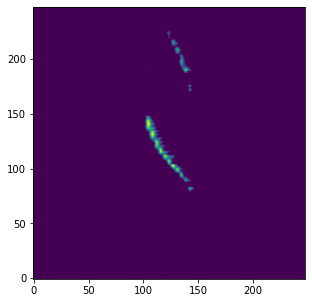

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2989 of 3030 ...
NB_26785x28444_ltr1_pup2_ch3_7700_f_317_314_fr0_p13_2021-09-27_10-05-33_clip_252.wav


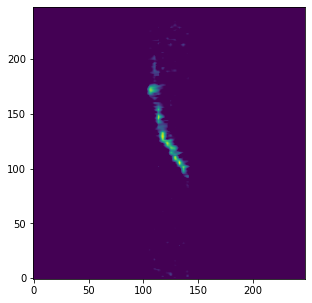

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2990 of 3030 ...
NB_27531x28557_ltr2_pup2_ch3_5100_f_344_303_fr0_p9_2021-11-01_09-28-29_clip_291.wav


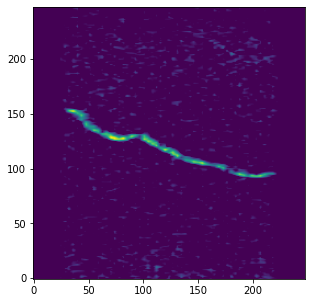

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2991 of 3030 ...
NB_28556x27320_ltr2_pup1_ch2_2400_m_345_273_fr0_p5_2021-11-17_09-22-32_clip_335.wav


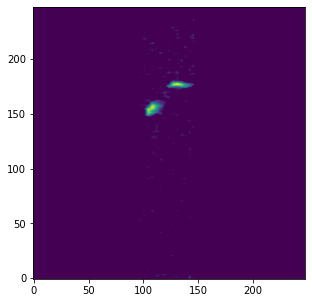

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2992 of 3030 ...
NB_28556x27320_ltr1_pup5_ch6_5700_m_307_306_fr0_p13_2021-08-12_12-41-41_clip_117.wav


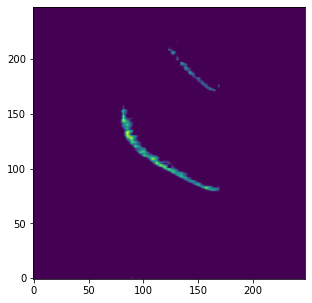

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2993 of 3030 ...
NB_28995x28876_ltr1_pup1_ch2_6900_m_318_302_fr0_p13_2021-08-12_12-12-41_clip_706.wav


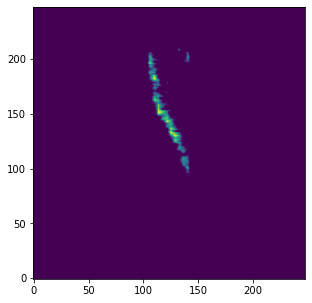

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2994 of 3030 ...
NB_26785x28444_ltr1_pup1_ch2_8000_m_316_320_fr0_p13_2021-09-27_10-05-33_clip_370.wav


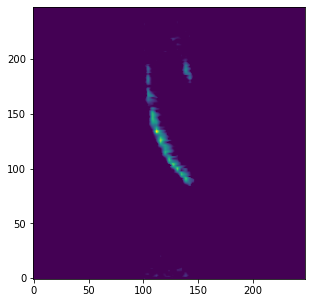

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2995 of 3030 ...
NB_28995x28876_ltr1_pup1_ch2_6900_m_318_302_fr0_p13_2021-08-12_12-12-41_clip_181.wav


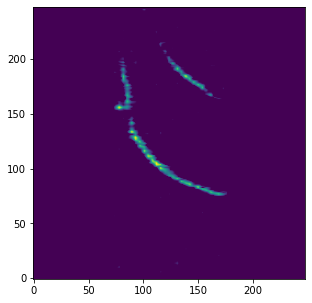

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2996 of 3030 ...
NB_28307x26627_ltr1_pup3_ch4_2300_m_342_266_fr0_p5_2021-12-15_11-10-35_clip_158.wav


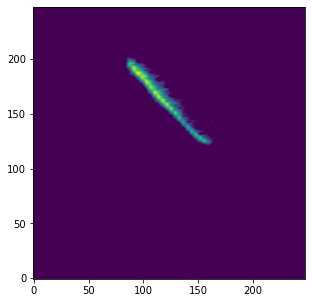

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2997 of 3030 ...
NB_28556x27320_ltr1_pup5_ch6_5700_m_307_306_fr0_p13_2021-08-12_12-41-41_clip_487.wav


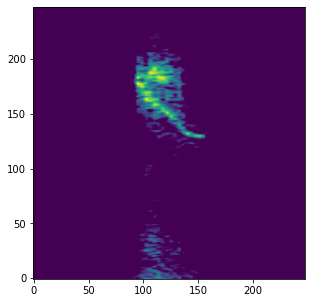

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2998 of 3030 ...
NB_28556x27320_ltr1_pup2_ch3_6400_m_306_314_fr0_p13_2021-08-12_12-41-41_clip_376.wav


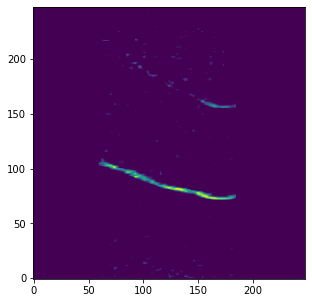

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 2999 of 3030 ...
NB_28995x28876_ltr1_pup1_ch2_6900_m_318_302_fr0_p13_2021-08-12_12-12-41_clip_99.wav


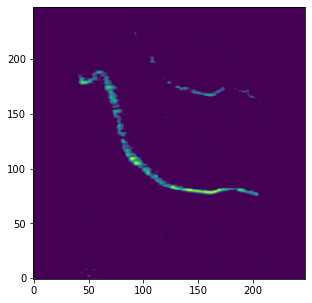

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3000 of 3030 ...
NB_28995x28876_ltr1_pup1_ch2_6900_m_318_302_fr0_p13_2021-08-12_12-12-41_clip_829.wav


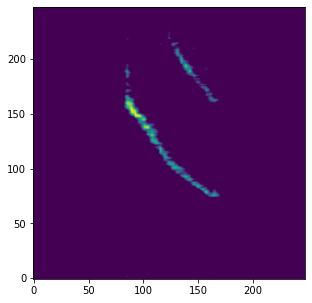

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3001 of 3030 ...
NB_28995x28876_ltr1_pup2_ch3_6400_f_321_318_fr0_p13_2021-08-12_12-12-41_clip_93.wav


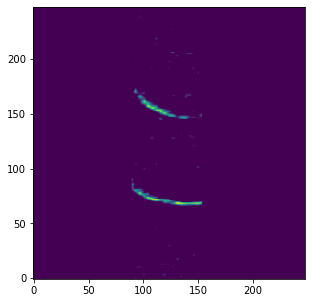

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3002 of 3030 ...
NB_28556x27320_ltr1_pup5_ch6_5700_m_307_306_fr0_p13_2021-08-12_12-41-41_clip_39.wav


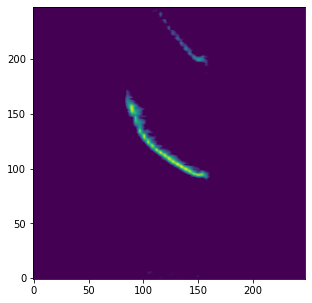

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3003 of 3030 ...
NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13_clip_915.wav


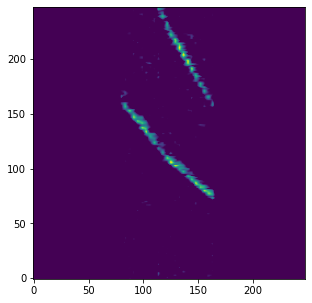

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3004 of 3030 ...
NB_26481x26788_ltr1_pup5_ch6_4300_m_333_287_fr0_p9_2021-08-06_12-59-17_clip_499.wav


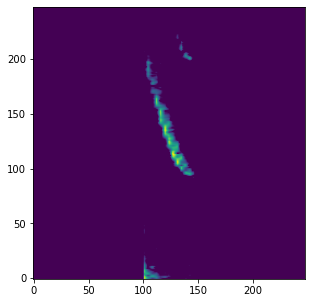

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3005 of 3030 ...
NB_28307x26627_ltr1_pup1_ch2_3500_m_356_296_fr0_p5_2021-12-15_11-10-35_clip_120.wav


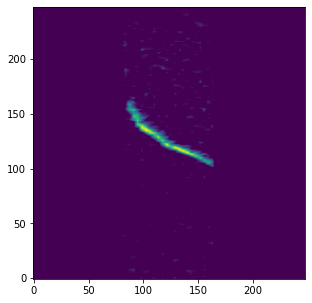

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3006 of 3030 ...
NB_26481x26788_ltr1_pup5_ch6_4300_m_333_287_fr0_p9_2021-08-06_12-59-17_clip_575.wav


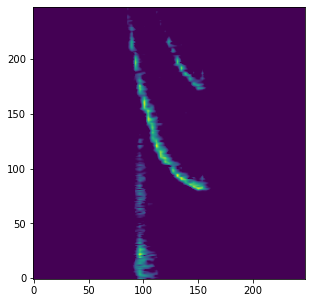

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3007 of 3030 ...
NB_28556x27320_ltr1_pup2_ch3_6400_m_306_314_fr0_p13_2021-08-12_12-41-41_clip_298.wav


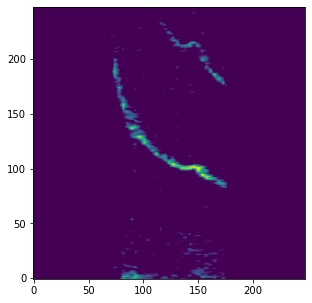

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3008 of 3030 ...
NB_28995x28876_ltr2_pup1_ch2_6700_m_334_327_fr0_p9_2021-10-06_11-26-13_clip_669.wav


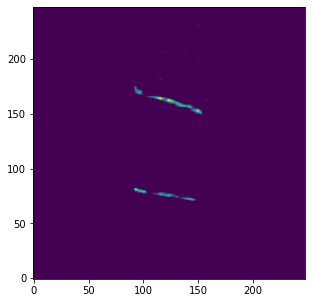

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3009 of 3030 ...
NB_28556x27320_ltr1_pup2_ch3_6400_m_306_314_fr0_p13_2021-08-12_12-41-41_clip_41.wav


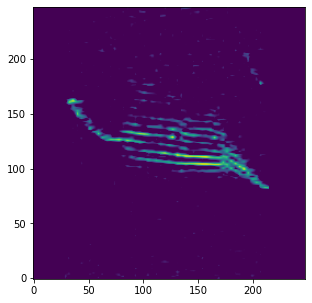

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3010 of 3030 ...
NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13_clip_620.wav


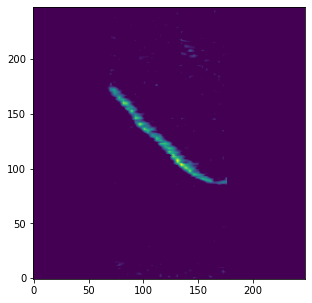

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3011 of 3030 ...
NB_26785x28444_ltr1_pup1_ch2_8000_m_316_320_fr0_p13_2021-09-27_10-05-33_clip_621.wav


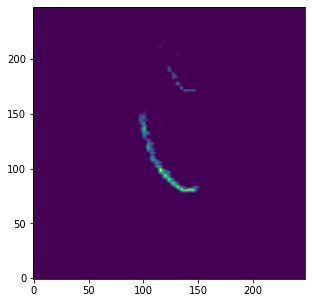

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3012 of 3030 ...
NB_28556x27320_ltr2_pup1_ch2_2400_m_345_273_fr0_p5_2021-11-17_09-22-32_clip_688.wav


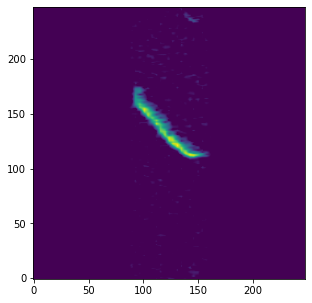

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3013 of 3030 ...
NB_28556x27320_ltr1_pup2_ch3_6400_m_306_314_fr0_p13_2021-08-12_12-41-41_clip_16.wav


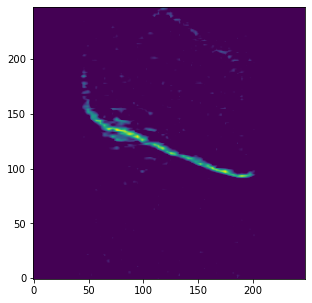

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3014 of 3030 ...
NB_28995x28876_ltr3_pup1_ch2_4100_m_339_297_fr0_p7_2021-10-25_09-16-38_clip_12.wav


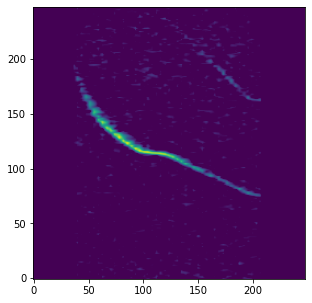

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3015 of 3030 ...
NB_26785x28444_ltr1_pup1_ch2_8000_m_316_320_fr0_p13_2021-09-27_10-05-33_clip_50.wav


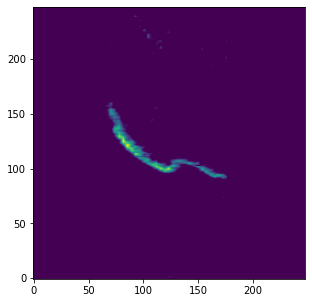

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3016 of 3030 ...
NB_28321x27533_ltr1_pup5_ch6_5200_m_313_286_fr0_p11_2021-08-11_12-26-05_clip_625.wav


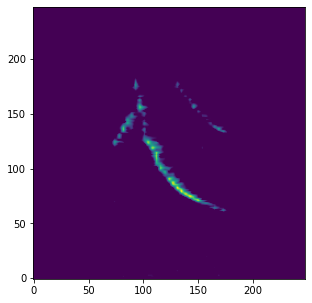

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3017 of 3030 ...
NB_28556x27320_ltr1_pup5_ch6_5700_m_307_306_fr0_p13_2021-08-12_12-41-41_clip_105.wav


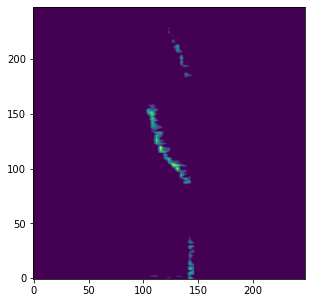

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3018 of 3030 ...
NB_28995x28876_ltr2_pup1_ch2_6700_m_334_327_fr0_p9_2021-10-06_11-26-13_clip_418.wav


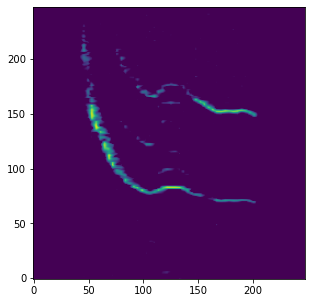

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3019 of 3030 ...
NB_26785x28444_ltr1_pup1_ch2_8000_m_316_320_fr0_p13_2021-09-27_10-05-33_clip_378.wav


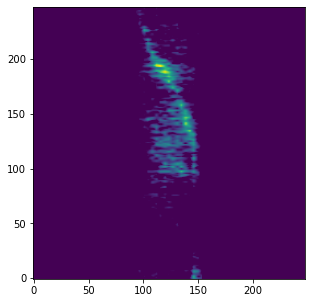

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3020 of 3030 ...
NB_26785x28444_ltr1_pup1_ch2_8000_m_316_320_fr0_p13_2021-09-27_10-05-33_clip_617.wav


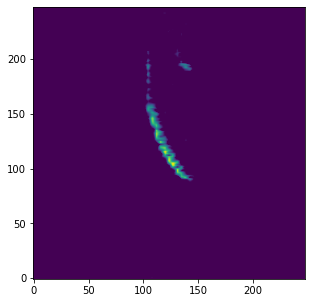

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3021 of 3030 ...
NB_28556x27320_ltr1_pup2_ch3_6400_m_306_314_fr0_p13_2021-08-12_12-41-41_clip_43.wav


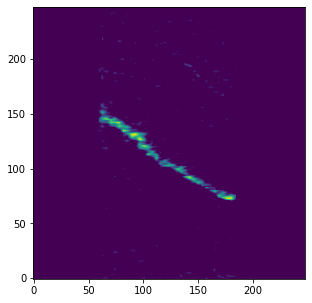

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3022 of 3030 ...
NB_26481x26788_ltr1_pup6_ch7_4300_m_331_275_fr0_p9_2021-08-06_12-59-17_clip_359.wav


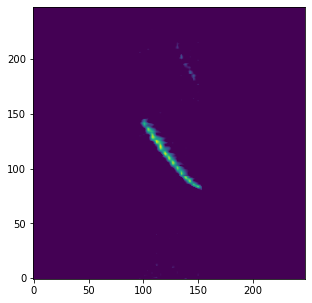

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3023 of 3030 ...
NB_28321x27533_ltr1_pup3_ch4_4900_m_321_289_fr0_p11_2021-08-11_12-26-05_clip_114.wav


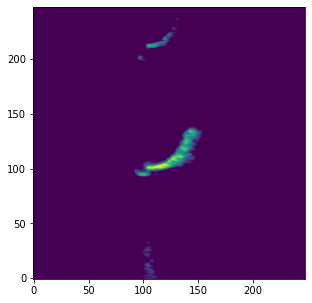

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3024 of 3030 ...
NB_26481x26788_ltr1_pup5_ch6_4300_m_333_287_fr0_p9_2021-08-06_12-59-17_clip_3.wav


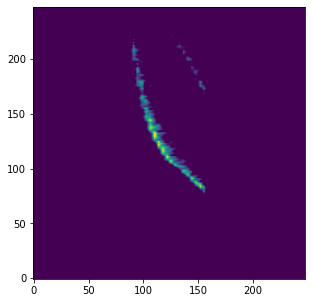

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3025 of 3030 ...
NB_28556x27320_ltr2_pup1_ch2_2400_m_345_273_fr0_p5_2021-11-17_09-22-32_clip_255.wav


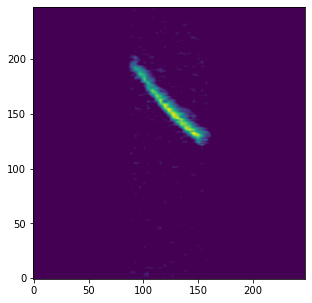

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3026 of 3030 ...
NB_26481x26788_ltr1_pup5_ch6_4300_m_333_287_fr0_p9_2021-08-06_12-59-17_clip_121.wav


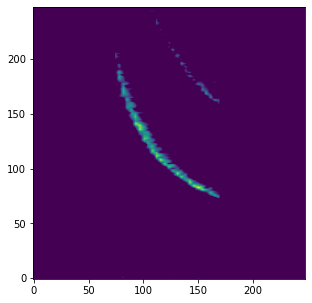

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3027 of 3030 ...
NB_28995x28876_ltr1_pup1_ch2_6900_m_318_302_fr0_p13_2021-08-12_12-12-41_clip_136.wav


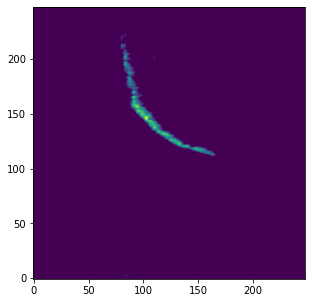

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3028 of 3030 ...
NB_28306x26626_ltr1_pup5_ch6_5200_f_326_304_fr0_p11_2021-10-04_10-04-13_clip_206.wav


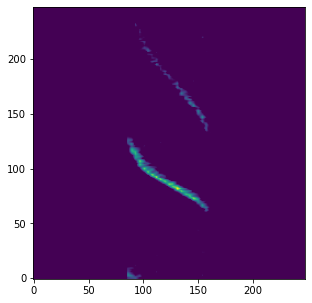

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
saving progress...
vocalization 3029 of 3030 ...
NB_28556x27320_ltr1_pup2_ch3_6400_m_306_314_fr0_p13_2021-08-12_12-41-41_clip_117.wav


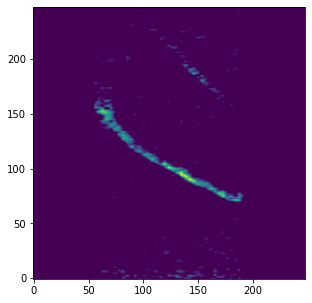

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotated
ok - whistle
you've annotated all the vocalizations in the data frame...saving
done.


In [1232]:
# now hand annotate them - this is easiest if this is the last cell in the notebook - consider temporaroly moving it there

#for viewing specs with different param than used in embedding
spec_params = {
    'min_freq': 5000, # minimum frequency
    'max_freq': 125000, # maximum frequency
    'nperseg': 512, # FFT
    'noverlap': 512 // 4, # FFT
    'spec_min_val': .1, # minimum log-spectrogram value - update from noise floors dataframe if noise_floors_path provided
    'fs': 250000, # audio samplerate
    'downsample_by':2, #2 means take every other pixel from the original spectrogram
    'log_resize_scaling_factor':None, 
    'fill_value': .1,
    'max_dur':.1,
    'num_time_bins':248,
    'num_freq_bins':248,
    'spec_max_val':10,
    'interpolate':True, 
    'noise_floors_path':None
}

#interactive annotation
non_spec_columns = ['source_file', 'umap1', 'umap2', 'label']
df_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+sampling_params['species']+'/annotations/hdbscan_label_'+str(sampling_params['hdbscan_label'])+'/'
df_save_name = sampling_params['species']+'_'+'hdbscan_label'+str(sampling_params['hdbscan_label'])+'_iteration'+str(sampling_params['sampling_iteration'])+'.feather'
hand_labeled_df = annotations_from_umap(downsampled_frame = ds_df, 
                                        num_freq_bins=128, 
                                        num_time_bins=128, 
                                        non_spec_columns=non_spec_columns, 
                                        sampling_params=sampling_params, 
                                        clips_dir=clips_dir, 
                                        spec_type='from_wav', 
                                        df_save_dir = df_save_dir, 
                                        df_save_name = df_save_name, 
                                        spec_params=spec_params)




# generate labeled background audio

In [457]:
#check if any background params exist for this species
species = 'MU'
bg_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/background/'
sorted(os.listdir(bg_dir))

['MU_31064x31067_ltr1_pup1_ch1_3600_m_347_285_fr0_p7_2021-09-20_09-55-11_background.feather',
 'MU_31064x31067_ltr1_pup1_ch1_3600_m_347_285_fr0_p7_2021-09-20_09-55-11_background_cleaned.feather',
 'MU_31064x31067_ltr1_pup1_ch1_3600_m_347_285_fr0_p7_2021-09-20_09-55-11_background_cleaned_round2.feather',
 'MU_31064x31067_ltr1_pup5_ch5_3500_f_354_278_fr0_p7_2021-09-20_09-55-11_background.feather',
 'MU_31064x31067_ltr1_pup5_ch5_3500_f_354_278_fr0_p7_2021-09-20_09-55-11_background_cleaned.feather',
 'MU_31064x31067_ltr1_pup5_ch5_3500_f_354_278_fr0_p7_2021-09-20_09-55-11_background_cleaned_round2.feather',
 'MU_31064x31067_ltr1_pup8_ch8_3600_m_348_286_fr0_p7_2021-09-20_09-55-11_background.feather',
 'MU_31064x31067_ltr1_pup8_ch8_3600_m_348_286_fr0_p7_2021-09-20_09-55-11_background_cleaned.feather',
 'MU_31064x31067_ltr1_pup8_ch8_3600_m_348_286_fr0_p7_2021-09-20_09-55-11_background_cleaned_round2.feather',
 'MU_31064x31067_ltr3_pup2_ch3_2100_f_346_269_fr0_p5_2021-11-24_11-16-47_background.f

In [459]:
temp = pd.read_feather(bg_dir+'all_background_cleaned_round2.feather')
temp['vocalizations_present?'].unique()

array(['no_voc'], dtype=object)

In [449]:
# os.remove(bg_dir+'NB_27531x28557_ltr2_pup3_ch4_4900_m_331_292_fr0_p9_2021-11-01_09-28-29_background.feather_background.feather')
# os.remove(bg_dir+'NB_27531x28557_ltr2_pup3_ch4_4900_m_331_292_fr0_p9_2021-11-01_09-28-29_background_cleaned.feather')

In [450]:
#set new background labeleing parameters and confirm overwrite twice
bg_clips_dir = all_bg_clips_dirs+species+'/'
bg_labeling_params = {'species': species, 
                   'sampling_iteration':2, 
                   'clips_dir':bg_clips_dir, 
                   'nperseg': 512,
                   'noverlap': 512//2, 
                   'type': 'background'
                   }

#choose save location and name
bg_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/background/'
save_name = bg_labeling_params['species'] + '_background'+'_iteration'+str(bg_labeling_params['sampling_iteration'])

#save the parameters
save_parameters(params = bg_labeling_params,
                save_dir=bg_dir, 
                save_name=save_name)

#if a directory doesn't exist for this iteration make it
inprogress_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/in_progress/background/'
iteration_dir = 'iteration'+str(bg_labeling_params['sampling_iteration'])
if iteration_dir not in os.listdir(inprogress_dir):
    os.mkdir(inprogress_dir+'iteration'+str(bg_labeling_params['sampling_iteration']))



no file with save_name existed in save_dir...saved the params


In [451]:
os.listdir(inprogress_dir)

['iteration1', 'iteration2']

In [452]:
#load them if you want
bg_labeling_params = load_parameters(save_dir=bg_dir, 
                            save_name=species+'_background_iteration2')

loaded parameters from /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/MU/annotations/background/MU_background_iteration2


In [453]:
# #get the labeling parameters
bg_labeling_params = load_parameters(save_dir=bg_dir, 
                                  save_name=species+'_background_iteration2')

#choose the pup to annoatate
pups = [i.split('_backgroundclip')[0] for i in os.listdir(bg_labeling_params['clips_dir'])]
pup = random.sample(pups, 1)[0]

loaded parameters from /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/MU/annotations/background/MU_background_iteration2



################################
labeling background from pup LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45 
################################

starting from scratch - no previously annotated vocalizations from this sampling params dictionary
['iteration1']
0 have been annotated from other iterations
0 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_88.wav
		clip duration (s) 0.182512


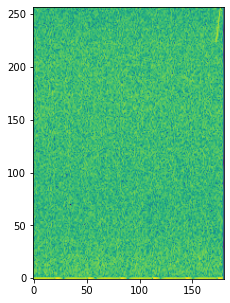

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
0.182512 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_73.wav
		clip duration (s) 7.96286


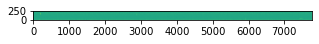

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exitx
how many seconds into this clip do you want it to start?.05
how many seconds before the end of this clip do you want it to end?.05
		new duration is 7.85286


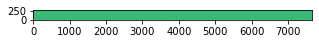

Are there vocalizations in this image? q for yes | a for no | s for skipa
		ok - recording
8.035371999999999 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_338.wav
		clip duration (s) 14.072052


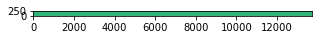

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exitx
how many seconds into this clip do you want it to start?.05
how many seconds before the end of this clip do you want it to end?.05
		new duration is 13.962052


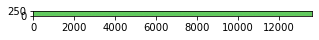

Are there vocalizations in this image? q for yes | a for no | s for skipa
		ok - recording
21.997424 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_246.wav
		clip duration (s) 0.182512


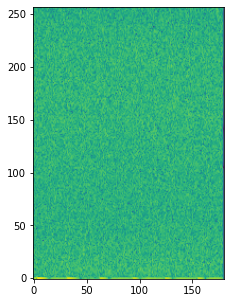

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
22.179935999999998 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_259.wav
		clip duration (s) 11.106544


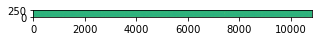

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exitx
how many seconds into this clip do you want it to start?.05
how many seconds before the end of this clip do you want it to end?.05
		new duration is 10.996544


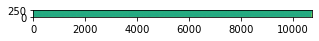

Are there vocalizations in this image? q for yes | a for no | s for skipa
		ok - recording
33.17648 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_93.wav
		clip duration (s) 0.055536


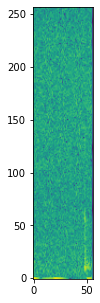

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
33.232015999999994 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_308.wav
		clip duration (s) 0.162032


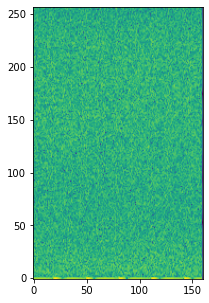

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
33.394048 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_112.wav
		clip duration (s) 0.13336


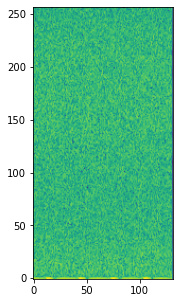

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
33.527408 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_313.wav
		clip duration (s) 1.511664


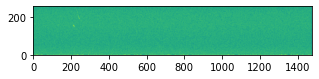

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exits
		SKIPPING to the next CLIP...
33.527408 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_15.wav
		clip duration (s) 0.395504


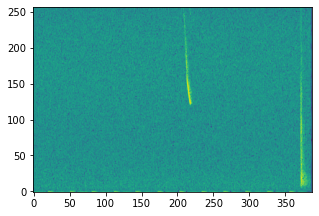

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
33.922912000000004 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_256.wav
		clip duration (s) 0.209136


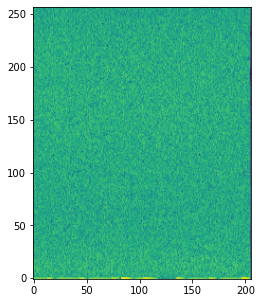

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
34.132048000000005 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_299.wav
		clip duration (s) 0.178416


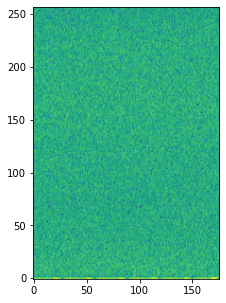

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
34.310464 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_332.wav
		clip duration (s) 0.227568


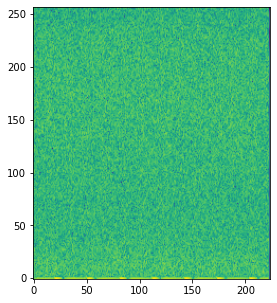

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
34.538032 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_215.wav
		clip duration (s) 0.202992


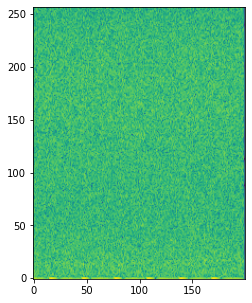

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
34.741024 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_211.wav
		clip duration (s) 0.045296


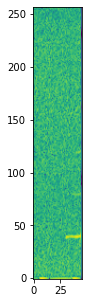

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exits
		SKIPPING to the next CLIP...
34.741024 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_193.wav
		clip duration (s) 0.227568


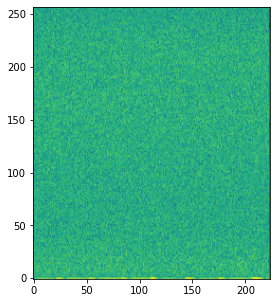

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
34.968592 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_140.wav
		clip duration (s) 0.284912


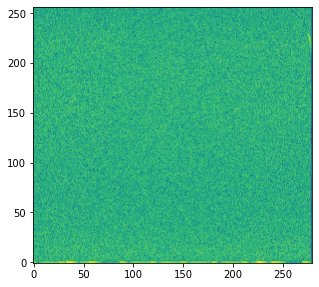

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
35.253504 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_206.wav
		clip duration (s) 0.229616


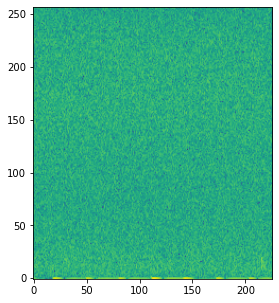

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exita
		ok - recording
35.48312 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_322.wav
		clip duration (s) 18.368752


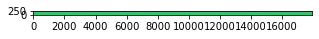

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exitx
how many seconds into this clip do you want it to start?.05
how many seconds before the end of this clip do you want it to end?.05
		new duration is 18.258752


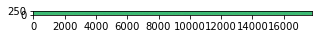

Are there vocalizations in this image? q for yes | a for no | s for skipa
		ok - recording
53.741872 seconds of audio annotated from this pup...
saving progress...

LL_24189x24129_ltr2_pup1_ch2_nan_nan_nan_nan_nan_p5_2019-11-13_08-59-45_backgroundclip_80.wav
		clip duration (s) 2.332912


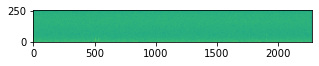

Are there vocalizations in this image?
q for yes | a for no | u for undo | s to skip to the next clip | x to clip | e to save and exite
exiting...
you annotated 19 clips amounting to 53.741872 seconds of background audio...
returning the labeled vocalizations to you...


In [442]:

#annotate
inprogress_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+bg_labeling_params['species']+'/annotations/in_progress/'+'background'+'/'+'iteration'+str(bg_labeling_params['sampling_iteration'])+'/'
label_save_name = pup+'_background.feather'
bg_annotations = annotations_from_background(species=bg_labeling_params['species'], 
                                             bg_labeling_params = bg_labeling_params, 
                                             bg_clips_dir=bg_labeling_params['clips_dir'], 
                                             df_save_dir=bg_dir, 
                                             df_save_name=label_save_name, 
                                             pup=pup, 
                                             inprogress_dir=inprogress_dir)


In [443]:
# #check for duplicates
# print(len(bg_annotations))
# print(len(bg_annotations.drop_duplicates()))

19
19


In [454]:
#remove rows that contain vocalizations ("clean")
to_process = [i for i in os.listdir(bg_dir) if '_background.feather' in i and 'cleaned' not in i]
for pup in to_process:
    cleaned_df_save_name = pup.split('.')[0]+'_cleaned_round2'+'.feather'
    temp = pd.read_feather(bg_dir+pup)
    temp = temp.loc[temp['vocalizations_present?'] == 'no_voc']
    temp = temp.reset_index(drop=True)
    temp.to_feather(bg_dir+cleaned_df_save_name)


In [ ]:
# combine annotations from different pups into a single dataframe
filter_string = '_cleaned_round2' 
file_format = '.feather'
combined_df = combine_dataframes(source_dir = bg_dir, 
                                 save_dir = bg_dir, 
                                 save_name = 'all_background_cleaned_round2',
                                 filter_string = filter_string, 
                                 file_format = file_format)

#check there are no duplicates
dropped_combined_df = combined_df.drop_duplicates()
print('\nTotal of', sum(combined_df['duration_s']), 'seconds annotated for', species, 'before duplicates dropped')
print('\nTotal of', sum(dropped_combined_df['duration_s']), 'seconds annotated for', species, 'after duplicates dropped')

In [455]:
#check how much background you have actually annotated and if there are any dublicates

total_annotated = []
to_check = [i for i in os.listdir(bg_dir) if i.endswith('.feather')]
for i in sorted(to_check):
    temp = pd.read_feather(bg_dir+i)
    print(i)
    print('len:', len(temp))
    print('num duplicates:', sum(temp.duplicated(subset='source_file')))
    print('total time annotated:', sum(temp['duration_s'].loc[temp['vocalizations_present?'] == 'no_voc']))
    total_annotated.append(sum(temp['duration_s'].loc[temp['vocalizations_present?'] == 'no_voc']))
print(sum(total_annotated))

# clean labeled vocalizations and generate wav files and annotations

## make a datframe for each vocalization you labeled

In [1356]:
#combine all the iterations

#choose the species
species_list = ['BW']
hdbscan_label = '1'

#bad pups - these are pups I discovered had recording artefacts (ie many vertical lines) while annotating
bad_pups = ['BK_26464x25680_ltr4_pup7_ch8_4500_f_355_318_fr0_p7_2021-11-24_09-42-41',
            'BK_26464x25680_ltr4_pup7_ch8_4500_f_355_318_fr0_p7_2021-11-24_09-42-41',
            'GO_24860x23748_ltr2_pup4_ch5_4700_m_324_292_fr0_p9_2021-10-02_12-35-01',
            'GO_23883x23084_ltr2_pup4_ch6_6100_f_329_304_fr0_p11_2019-12-03_10-35-37', 
            'NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13', 
            'SW_29542x30031_ltr1_pup7_ch8_1600_m_348_263_fr0_p1_2022-01-05_10-54-58', 
            'MU_31064x31067_ltr1_pup1_ch1_3600_m_347_285_fr0_p7_2021-09-20_09-55-11', 
            'MU_31063x31066_ltr1_pup8_ch8_1600_m_338_253_fr0_p3_2021-09-23_12-31-47', 
            'MU_31064x31067_ltr1_pup1_ch1_3600_m_347_285_fr0_p7_2021-09-20_09-55-11', 
            'MU_31063x31066_ltr2_pup7_ch8_4400_f_339_305_fr0_p11_2022-01-24_09-30-16', 
            'MU_31063x31066_ltr1_pup8_ch8_1600_m_338_253_fr0_p3_2021-09-23_12-31-47']

for species in species_list:
    print(species)
    df_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/hdbscan_label_'+hdbscan_label+'/'
    if hdbscan_label == '0':
        if species == 'MU':
            iteration1 = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration1.feather'))
            iteration2 = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration2.feather'))
            iteration3 = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration3.feather'))
            all_vocs = pd.concat([iteration1,iteration2,iteration3])
            
        elif species == 'LO': #LO only has one iteration 
            all_vocs = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration1.feather'))
        else:  
            iteration1 = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration1.feather'))
            iteration2 = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration2.feather'))
            all_vocs = pd.concat([iteration1,iteration2])

        print('dropping', sum(all_vocs.duplicated(subset='source_file')), 'duplicate rows...')
        all_vocs = all_vocs.drop_duplicates(subset=['source_file'])
        all_vocs = all_vocs.reset_index(drop=True)
        
        
        all_vocs['pup'] = [i.split('_clip')[0] for i in all_vocs['source_file']]
        print('dropping', len(all_vocs.loc[all_vocs['pup'].isin(bad_pups)]), 'vocs from bad pups...')
        all_vocs = all_vocs.loc[~all_vocs['pup'].isin(bad_pups)]
        all_vocs = all_vocs.reset_index(drop=True)

        print('saving...')
        all_vocs.to_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_all.feather'))

        print('done.')

    elif hdbscan_label == '1': #only Pero have a label 1 and they all only have 1 iteration of annotation right now
        if species in ['MU', 'MZ']:
            continue

        elif species in ['BW', 'BK', 'SW', 'NB', 'PO', 'LO', 'GO', 'LL']:
            all_vocs = pd.read_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_iteration1.feather'))
            
            print('dropping', sum(all_vocs.duplicated(subset='source_file')), 'duplicate rows...')
            all_vocs = all_vocs.drop_duplicates(subset=['source_file'])
            all_vocs = all_vocs.reset_index(drop=True)

            all_vocs['pup'] = [i.split('_clip')[0] for i in all_vocs['source_file']]
            print('dropping', len(all_vocs.loc[all_vocs['pup'].isin(bad_pups)]), 'vocs from bad pups...')
            all_vocs = all_vocs.loc[~all_vocs['pup'].isin(bad_pups)]
            all_vocs = all_vocs.reset_index(drop=True)

            print('saving...')
            all_vocs.to_feather(os.path.join(df_save_dir,species+'_hdbscan_label'+hdbscan_label+'_all.feather'))

            print('done.')


BW
dropping 0 duplicate rows...
dropping 0 vocs from bad pups...
saving...
done.


# optional: generate wav files in which annotated vocs are interleved with random background and save corresponding csvs of their start and stop times

In [1357]:
#choose the species and label
hdbscan_label = '1'
species_list = ['BW']

#this is the a blank (no mouse in the box) 25 ms file from the recording set up used to record 'BK', 'SW', 'NB', 'PO', 'LO', 'GO', 'LL', 'MU'
lab_spacer_wav = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/00_params/spacer_ch2_background_2019-09-04_13-16-26_25ms.wav'

#this is a 25 ms clip with no vocalizatons from a barn recording (mouse was in the box but I verified this clip has no vocalizations)
wild_spacer_wav = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/00_params/MZ_box20_p7_pup2_2022-07-21_12-38-47_25ms_silence.wav'

for species in species_list:
    print(species)
    
    #get the dataframe that has all of the annotations (no need to split into vocal and nonvocal)
    df_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/hdbscan_label_'+hdbscan_label
    df_save_name = species+'_'+'hdbscan_label'+hdbscan_label+'_all'+'.feather'
    hand_labeled_df = pd.read_feather(os.path.join(df_save_dir,df_save_name))

    #make sure you have all the annotations you expect
    if species in ['BW', 'BK', 'SW', 'NB', 'PO', 'LO', 'GO', 'LL']:
        print(hand_labeled_df['human_label'].unique())
        human_labels = list(hand_labeled_df['human_label'].unique())
        
    elif species in ['MU', 'MZ']: # these don't have cries
        set(hand_labeled_df['human_label'].unique()) == set(['whistle', 'scratch', 'none'])
        human_labels = ['whistle', 'scratch']

    voc_clips_dir = os.path.join(all_voc_clips_dirs,species)+'/'

    #for each label, get it from the big dataframe then save the annotations and concatenate the wav file
    for human_label in human_labels:

        #get the clips with the current label
        cleaned_voc = hand_labeled_df.loc[hand_labeled_df['human_label'] == human_label]
        #define the save directory and save name
        save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/for_das/'
        annotations_save_name = ('_').join([species,'hdbscanLabel',hdbscan_label,'humanLabel',cleaned_voc['human_label'].unique()[0],'25msspacer','annotations'])
        voc_clips_list = cleaned_voc['source_file']
        
        if species == 'MZ':
            spacer_wav = wild_spacer_wav
        else:
            spacer_wav = lab_spacer_wav

        #make the annotations and wav file
        df = concat_annotated_clips(voc_clips_dir = voc_clips_dir, 
                            voc_clips_list = voc_clips_list,
                            save_dir = save_dir, 
                            spacer_wav = spacer_wav,
                            save_name = annotations_save_name, 
                            label = human_label, 
                            margin = 0)
    
print('done.')


BW
['cry' 'none' 'scratch' 'whistle']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2286/2286 [00:21<00:00, 104.50it/s]


done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 175.39it/s]


done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 182.81it/s]


done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.47it/s]


done.
done.


In [461]:
#write the human labeled wav file for the background
species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL', 'MU', 'MZ']

for species in species_list:
    bg_clips_dir = all_bg_clips_dirs + species + '/'
    bg_df_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/background/all_background_cleaned_round2.feather'
    save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/for_das/'
    save_name = species+'_'+'background_round2.wav'

    bg_df = pd.read_feather(bg_df_path)
    bg_df = bg_df.drop_duplicates(subset=['source_file']) #there shouldn't be any
    wav_from_background_annotations(frame=bg_df, 
                                    clips_dir=bg_clips_dir, 
                                    save_dir=save_dir, 
                                    save_name=save_name)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 733/733 [00:15<00:00, 47.15it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:27<00:00, 28.69it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 706/706 [00:20<00:00, 34.67it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 556/556 [00:20<00:00, 27.04it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:14<00:00, 14.45it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 577/577 [00:18<00:00, 30.85it/s]


done.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1576/1576 [00:36<00:00, 43.27it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 540/540 [00:22<00:00, 23.92it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 577/577 [00:23<00:00, 24.71it/s]


done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 933/933 [00:33<00:00, 27.60it/s]


done.
